## AFTER running your Neural Network and choosing your favorite model, see how inst freq impacts tau 1 and tau 2

In [1]:
import numpy as np
import shap
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorboard
import plotly
import plotly.express as px
from sklearn.metrics import r2_score
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
np.random.seed(42)

In [3]:
class Network(pl.LightningModule):
    def __init__(self, classes=10):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(200,100), #0
            torch.nn.ReLU(), #1
            torch.nn.Dropout(0.1),#2
            torch.nn.Linear(100,100),#3
            torch.nn.ReLU(), #4
            torch.nn.Linear(100,10), #5
            torch.nn.ReLU(),#6
            torch.nn.Linear(10,2) #7
            )
    def forward(self, x): #Calls model to return output (2 outputs in our case)
        return self.model(x)

    def training_step(self, batch, batch_idx): #Finding and logging the loss during training
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y) # L1 loss measures absolute distance to target
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx): #The 'Practice Test' to see how well the NN is doing
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)  # Log the test loss
        #self.log('y', y, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log('y_hat', y_hat, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [4]:
inputs = np.load('../20230726/input_array.npy')
outputs = np.load('../20230726/output_array.npy')

In [5]:
tensor_inputs = torch.from_numpy(inputs).float()
tensor_outputs = torch.from_numpy(outputs).float()

In [6]:
dataset = TensorDataset(tensor_inputs,tensor_outputs)

In [7]:
train = 7000
val = 1500
test = 1500
train_set, val_set, test_set = torch.utils.data.random_split(dataset,
    [train, val, test])

In [8]:
train_load = DataLoader(train_set, num_workers=5)
val_load = DataLoader(val_set, num_workers=5)
test_load = DataLoader(test_set, num_workers=5)

In [9]:
test_inputs = []
test_outputs = []
for x in test_load:
    #From dataloader test_load converted it's Tensor into numpy so we can graph
    #This is because it's harder to subscript as dataloader is an object and not a list
    test_inputs.append(x[0][0].detach().numpy()) 
    test_outputs.append(x[1][0].detach().numpy())

In [10]:
test_inputs = np.array(test_inputs)

In [11]:
test_inputs.shape

(1500, 200)

In [12]:
trained_model = Network().load_from_checkpoint('../20230726/lightning_logs/version_47/checkpoints/epoch-v40.ckpt')

In [13]:
device = torch.device('cuda')

In [14]:
def extract_tau1(data):
    outputs = []
    for i in range(data.shape[0]):
        output = trained_model(torch.from_numpy(data[i,:]).float().to(device))
        output = output.cpu().detach().numpy()[0]
        outputs.append(output)
    return np.array(outputs)

In [15]:
def extract_tau2(data):
    outputs = []
    for i in range(data.shape[0]):
        output = trained_model(torch.from_numpy(data[i,:]).float().to(device))
        output = output.cpu().detach().numpy()[1]
        outputs.append(output)
    return np.array(outputs)

In [16]:
explainer1 = shap.KernelExplainer(extract_tau1,
                                 shap.sample(np.array(test_inputs), nsamples=100))

In [17]:
explainer2 = shap.KernelExplainer(extract_tau2,
                                 shap.sample(np.array(test_inputs), nsamples=100))

In [18]:
test_outputs[0]

array([ 39.74349, 161.35783], dtype=float32)

In [19]:
test_outputs[1]

array([ 33.025856, 276.61526 ], dtype=float32)

In [30]:
test_outputs[5]

array([  2.409937, 336.8175  ], dtype=float32)

In [31]:
shap_vals_tau1 = explainer1.shap_values(test_inputs[5,:])
shap_vals_tau2 = explainer2.shap_values(test_inputs[5,:])

In [32]:
shap_vals_tau1.shape

(200,)

In [33]:
time = np.linspace(0.2,1.8,198)

Text(0.5, 1.0, 'SHAP Values for $\\tau_{1}$')

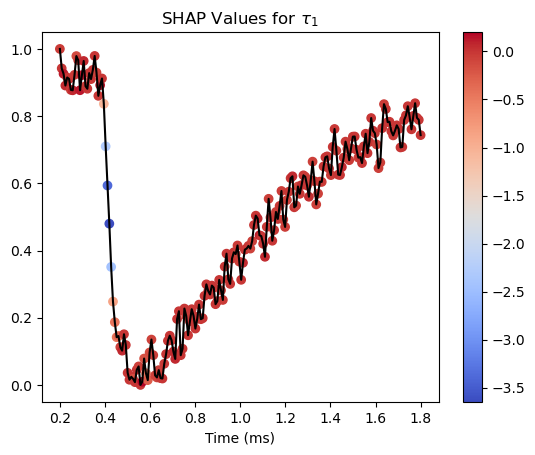

In [34]:
plt.plot(time, test_inputs[1,2:], color='k')
plt.scatter(time, test_inputs[1,2:], c=shap_vals_tau1[2:], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.title('SHAP Values for $\\tau_{1}$')

Text(0.5, 1.0, 'SHAP Values for $\\tau_{2}$')

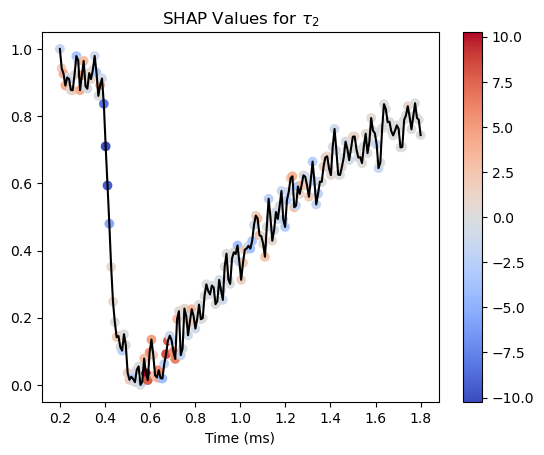

In [35]:
plt.plot(time, test_inputs[1,2:], color='k')
plt.scatter(time, test_inputs[1,2:], c=shap_vals_tau2[2:], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.title('SHAP Values for $\\tau_{2}$')